In [163]:
import sqlite3
import yfinance as yf
import pandas as pd

def connect_db(db_name, root_path = '/Users/qingfeng.yang/dev_workspace/python/sqlite_db'):
    db_file = root_path + '/' + db_name + '.db'
    conn = sqlite3.connect(db_file)
    return conn

def create_table(table_name):
    sql_drop_tbl = '''
        DROP TABLE IF EXISTS {tbl_name}
        '''.format(tbl_name = table_name)
    
    sql_create_tbl = '''
        CREATE TABLE if not exists {tbl_name}(
            t_date integer PRIMARY KEY,
            open_pr real,
            high_pr real,
            low_pr real,
            close_pr real,
            adj_close_pr real,
            volume integer
            )
        '''.format(tbl_name = table_name)
    try:
        conn = connect_db(db_name = table_name)
        cur = conn.cursor()
        cur.execute(sql_drop_tbl)
        cur.execute(sql_create_tbl)
        res = cur.execute("SELECT name FROM sqlite_master")
        print('Table: %s been created.'%(res))
    except sqlite3.Error as error:
        print("Error occurs when insert rows into table", error)
    finally:
        if conn:
            conn.close()
            print("The SQLite connection is closed")

def init_load_bulkdata(df, table_name):
    try:
        conn = connect_db(db_name = table_name)
        ret = df.to_sql(table_name, conn, if_exists='append', index=True, index_label='t_date')
        print('%s row insert into %s' % (ret, table_name))
    except sqlite3.Error as error:
        print("Error occurs when insert rows into table", error)
    finally:
        if conn:
            conn.close()
            print("The SQLite connection is closed")
            
def insert_data(df, table_name):
    sql_insert_with_param = '''INSERT or ignore INTO {tbl_name}
              (t_date, open_pr, high_pr, low_pr, close_pr, adj_close_pr, volume) 
              VALUES (?, ?, ?, ?, ?, ?, ?);
            '''.format(tbl_name = table_name)
    try:
        conn = connect_db(db_name = table_name)
        cur = conn.cursor()
        for index, row in df.iterrows():
            try:
                data_tuple = (index, row[0], row[1], row[2], row[3], row[4], row[5])
                cur.execute(sql_insert_with_param, data_tuple)
            except sqlite3.Error as error:
                print("Failed to insert row: %r , Error:%e" % (row, error))
        conn.commit()
    except sqlite3.Error as error:
        print("Error occurs when insert rows into table", error)
    finally:
        if conn:
            conn.close()
            print("The SQLite connection is closed")

def create_table_and_init_data(stock_symbol, table_name, months_num=1):
    # 1.create table for stock
    create_table(table_name)
    # 2.load data to db
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.DateOffset(months=months_num)
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    data_formated = format_dataframe(stock_data)
    init_load_bulkdata(data_formated, table_name)
    return stock_data

def format_dataframe(source_df):
    stock_test = source_df.rename(columns = {'Open':'open_pr'
                                              , 'High':'high_pr'
                                              , 'Low':'low_pr'
                                              , 'Close':'close_pr'
                                              , 'Adj Close':'adj_close_pr'
                                              , 'Volume':'volume'
                                            }, inplace = False)
    stock_test.index.names=['t_date']
    stock_test.index = stock_test.index.strftime('%Y%m%d')
    stock_test.index = stock_test.index.map(int)
    return stock_test

def reverse_format_dataframe(formated_df):
    df = formated_df.rename(columns = {'open_pr':'Open'
                                            , 'high_pr':'High'
                                            , 'low_pr':'Low'
                                            , 'close_pr':'Close'
                                            , 'adj_close_pr':'Adj Close'
                                            , 'volume':'Volume'
                                        }, inplace = False)
    df.index.names=['Date']
    df.index = pd.to_datetime(df.index.map(str),format='%Y%m%d')
    return df
    
# test integration with sqlite
def connect_db(db_name, root_path = '/Users/qingfeng.yang/dev_workspace/python/sqlite_db'):
    db_file = root_path + '/' + db_name + '.db'
    conn = sqlite3.connect(db_file)
    return conn

def read_data_from_sqlite(table_name, start_date, end_date):
    try:
        start_date_i = int(start_date.strftime('%Y%m%d'))
        end_date_i = int(end_date.strftime('%Y%m%d'))
        #end_date_i = int(datetime.today().strftime('%y%m%d'))
        conn = connect_db(db_name = table_name)
        sql = '''select * 
                from {tbl_name} 
                where t_date between {start_date} and {end_date}
                '''.format(tbl_name = table_name, start_date = start_date_i, end_date=end_date_i)
        #print('Executing sql: %s'%(sql))
        df = pd.read_sql(sql, conn, index_col='t_date')
        df = reverse_format_dataframe(df)
        return df
    except sqlite3.Error as error:
        print("Error occurs when insert rows into table", error)
    finally:
        if conn:
            conn.close()
            #print("The SQLite connection is closed")
        
def show_test_data(table_name):
    try:
        conn = connect_db(db_name = table_name)
        sql = 'select * from {}'.format(table_name)
        print(sql)
        df = pd.read_sql(sql, conn)
        print(df)
    except sqlite3.Error as error:
        print("Error occurs when insert rows into table", error)
    finally:
        if conn:
            conn.close()
            print("The SQLite connection is closed")

def test_whole_flow(symbol_name):
    # 1. Test create table
    print('--- Test create table')
    #symbol_name = 'test'
    table_name = 'stock_{}'.format('test')
    create_table(table_name)
    show_test_data(table_name)

    # 2. Test init_data
    print('--- Test init_data')
    stock_data = download_stock_data_save_db('META', table_name)
    stock_test = format_dataframe(stock_data)
    init_load_bulkdata(stock_test.iloc[[0, 2]], table_name)
    show_test_data(table_name)

    # 3.1 Test insert data
    print('--- 3.1 Test insert data')
    insert_data(stock_test.iloc[[0, 2]], table_name)
    show_test_data(table_name)

    # 3.2 Test insert data
    print('--- 3.2 Test insert data')
    insert_data(stock_test.iloc[[1, 5]], table_name)
    show_test_data(table_name)

    # 4. Test reformat
    print('--- 4. Test reformat')
    stock_test_df = reverse_format_dataframe(stock_test)
    print(stock_test_df.tail(3))
    
def main():
    assets_list = [('AAPL','AAPL'), 
                   ('META','META'), 
                   ('MSFT','MSFT'), 
                   ('NVDA','NVDA'), 
                   ('TSLA','TSLA'), 
                   ('0700.HK','TECENT')]
    #assets_list = ['META']
    for stock_symbol, cmp_name in (assets_list):
        table_name = 'stock_{}'.format(cmp_name)
        create_table_and_init_data(stock_symbol, table_name, 36)
        start_date = datetime.today() - timedelta(1)
        stock_data = read_data_from_sqlite(table_name, start_date, datetime.today())
        print(stock_data.tail(3))
        
if __name__ == "__main__":
    main()
    #test_whole_flow('test')

Table: <sqlite3.Cursor object at 0x125c20c00> been created.
The SQLite connection is closed
[*********************100%***********************]  1 of 1 completed
754 row insert into stock_AAPL
The SQLite connection is closed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-11-10  183.970001  186.570007  183.529999  186.399994  186.399994   

              Volume  
Date                  
2023-11-10  66133400  
Table: <sqlite3.Cursor object at 0x125c20650> been created.
The SQLite connection is closed
[*********************100%***********************]  1 of 1 completed
754 row insert into stock_META
The SQLite connection is closed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-11-10  319.940002  329.100006  319.459991  328.769989  328.769989   

              Volume  
Date          

+----------+----------------------+---------------------+
| Symbol   | Panic Sell           | Reversal            |
+==========+======================+=====================+
| AAPL     | 2023-10-20(172.88$), |                     |
|          | 2023-10-26(166.89$)  |                     |
+----------+----------------------+---------------------+
| META     | 2023-10-26(288.35$)  | 2023-10-26(288.35$) |
+----------+----------------------+---------------------+
| MSFT     |                      |                     |
+----------+----------------------+---------------------+
| NVDA     | 2023-10-19(421.01$), | 2023-10-31(407.8$)  |
|          | 2023-10-20(413.87$)  |                     |
+----------+----------------------+---------------------+
| TSLA     | 2023-10-19(220.11$), |                     |
|          | 2023-10-20(211.99$)  |                     |
+----------+----------------------+---------------------+
| TECENT   | 2023-10-24(283.0$),  |                     |
|          | 2

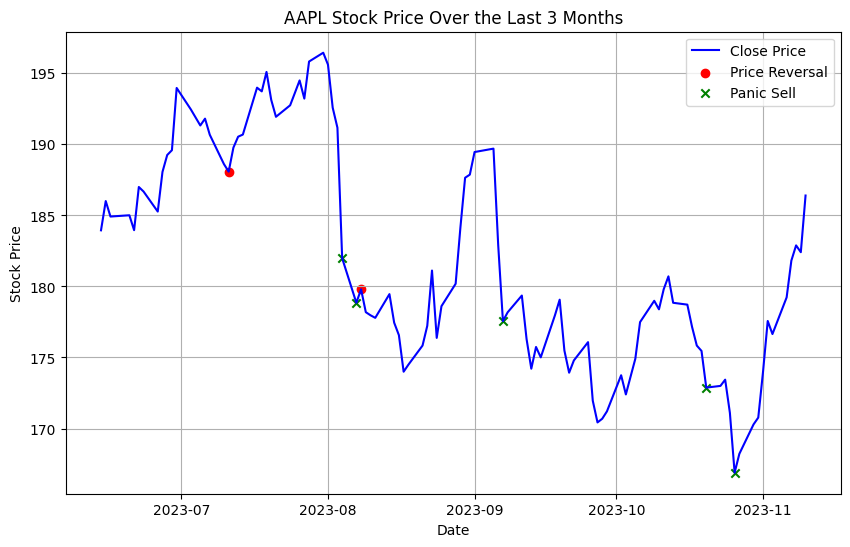

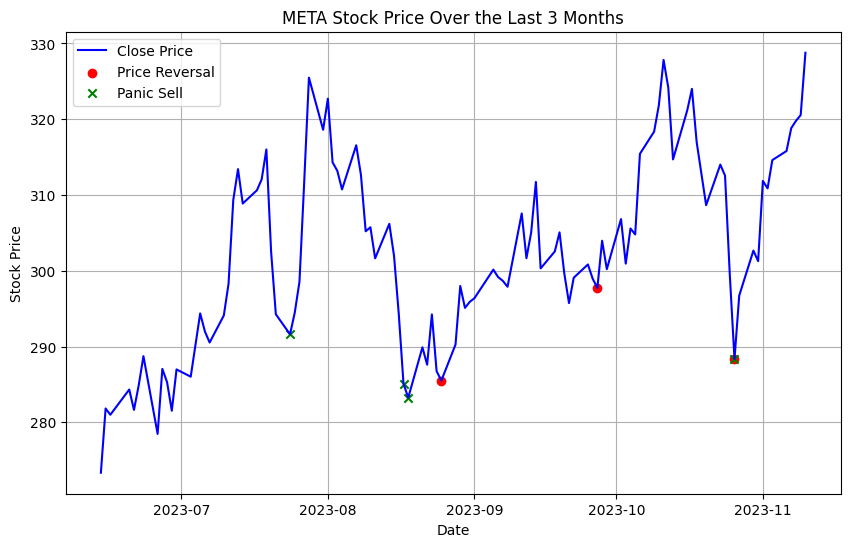

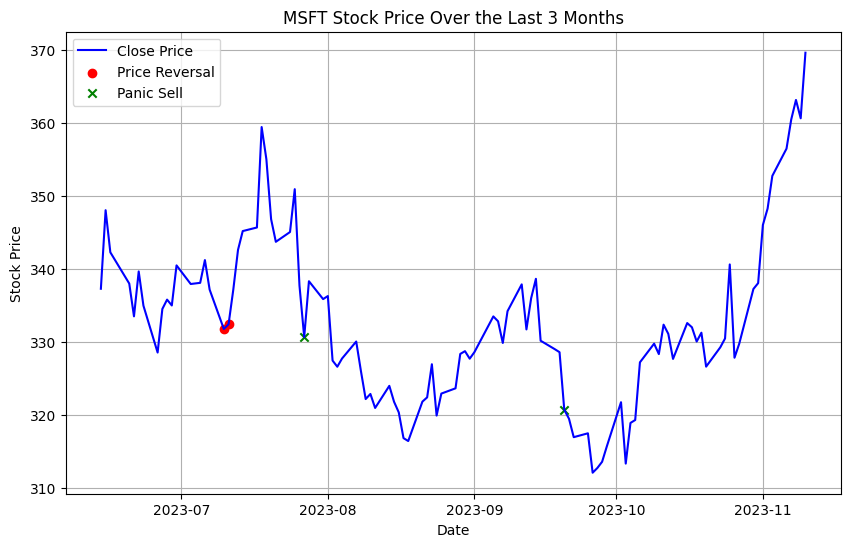

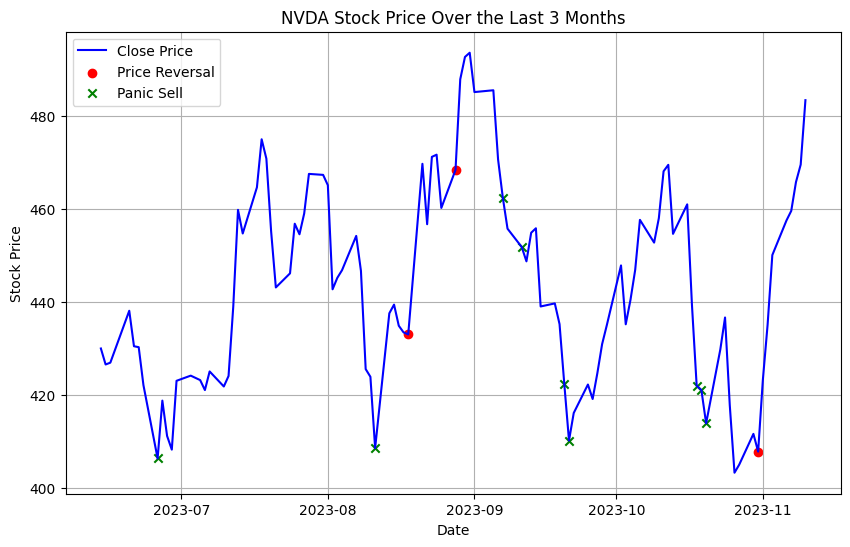

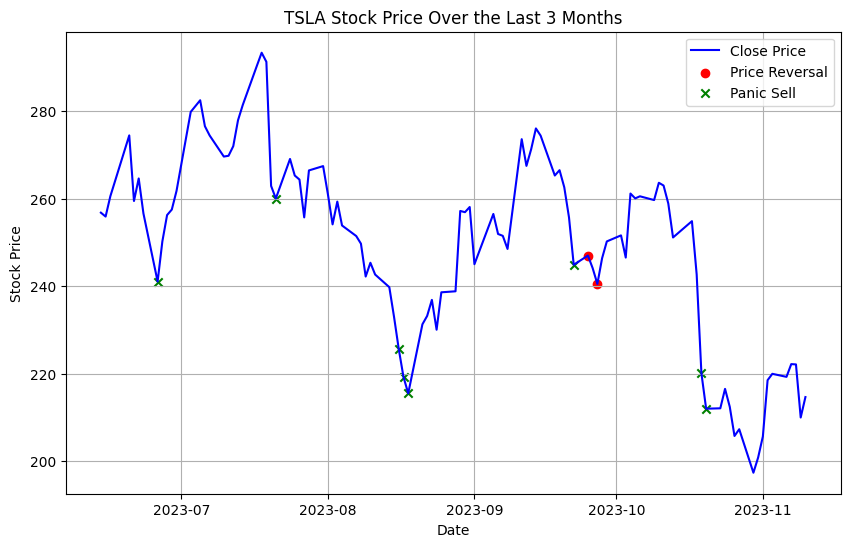

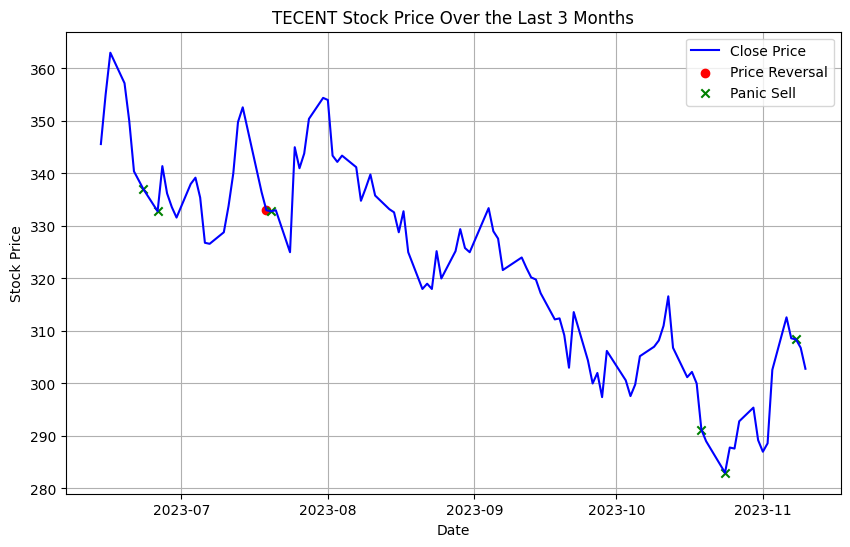

In [188]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from datetime import datetime, timedelta
import sqlite3

def calculate_rolling_average_volatility(stock_data, window=15):
    stock_data['Day_Volatility'] = stock_data['Close'].pct_change().abs() #TBD
    stock_data['Rolling_Avg_Volatility'] = stock_data['Day_Volatility'].rolling(window=window).mean()
    return stock_data

def calculate_rolling_average_price(stock_data, window=60):
    stock_data['Rolling_Avg_Price'] = stock_data['Close'].rolling(window=window).mean()
    return stock_data

def detect_price_reversal(stock_data, window=15):
    # 计算振幅
    stock_data['Daily_Amplitude'] = (stock_data['High'] - stock_data['Low'])/stock_data['Open']
    stock_data['NDays_Rolling_Amplitude'] = stock_data['Daily_Amplitude'].rolling(window=window).mean()
    
    stock_data.loc[:,['min_open_close']] = stock_data.loc[:,('Open','Close')].min(axis=1)
    stock_data.loc[:,['max_open_close']] = stock_data.loc[:,('Open','Close')].max(axis=1)
    stock_data['Price_Reversal'] = (
         (stock_data['Open'] < stock_data['Close'].shift(2))&
#         (stock_data['Close'].shift(1) < stock_data['Close'].shift(2))&
        #(stock_data['Open'] < stock_data['Rolling_Avg_Price'])&
        (stock_data['min_open_close'] - stock_data['Low'] >= (stock_data['High'] - stock_data['Low']) * 0.5)&
        (stock_data['High'] - stock_data['max_open_close'] <= (stock_data['High'] - stock_data['Low']) * 0.2)&
        (stock_data['Daily_Amplitude']> stock_data['NDays_Rolling_Amplitude'] * 0.8)
    )
    
    return stock_data[stock_data['Price_Reversal']]

def detect_panic_sell(stock_data):
    stock_data['3_Day_Volatility'] = stock_data['Close'].pct_change(4).abs()
    #stock_data['3_Day_Volatility'] = stock_data['Close'].shift(1) - stock_data['Close'].pct_change(4).abs()
    average_volatility = stock_data['Rolling_Avg_Volatility'].dropna().mean()
    stock_data['Panic_Sell'] = (
        (stock_data['Close'] < stock_data['Close'].shift(1)) &
        (stock_data['Close'].shift(1) < stock_data['Close'].shift(2)) &
        (stock_data['3_Day_Volatility'] >= 3.3 * average_volatility)
    )
    return stock_data[stock_data['Panic_Sell']]

def detect_good_call_position(stock_data):
    abnormal_reversal = detect_price_reversal(stock_data)
    abnormal_panic_sell = detect_panic_sell(stock_data)
    
    return abnormal_reversal, abnormal_panic_sell
    
def get_recent_abnormal_signal(panic_sell_df, reversal_signal_df, dayOffset = 15, show_point_num=2):
    start_date = datetime.today() - timedelta(dayOffset)
    
    panic_latest = panic_sell_df.loc[start_date:datetime.today()].tail(show_point_num)
    msg_pandic = ''
    for index, col in panic_latest['Close'].items():
        if len(msg_pandic) > 0:
            msg_pandic += ",\n"
        msg_pandic += '{}({}$)'.format(index.strftime('%Y-%m-%d'), round(col, 2))
    #print(msg_pandic)

    reversal_latest = reversal_signal_df.loc[start_date:datetime.today()].tail(show_point_num)
    msg_reversal = ''
    for index, col in reversal_latest['Close'].items():
        if len(msg_reversal) > 0:
            msg_reversal += ",\n"
        msg_reversal += '{}({}$)'.format(index.strftime('%Y-%m-%d'), round(col, 2))
    #print(msg_reversal)
    return (msg_pandic, msg_reversal)

def download_meta_stock_data(stock_symbol):
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.DateOffset(months=6)
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data


def plot_diagram(stock_symbol, stock_data, abnormal_reversal, abnormal_panic_sell):
    # 绘制图表并标记异常点
    plt.figure(figsize=(10, 6))
    plt.plot(stock_data.index, stock_data['Close'], label='Close Price', color='b')
    plt.scatter(abnormal_reversal.index, abnormal_reversal['Close'], color='r', marker='o', label='Price Reversal')
    plt.scatter(abnormal_panic_sell.index, abnormal_panic_sell['Close'], color='g', marker='x', label='Panic Sell')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.title('%s Stock Price Over the Last 3 Months'%(stock_symbol))
    plt.grid(True)
    plt.show()
    

def main(isPlot = 1):
    assets_list = [('AAPL','AAPL'), 
               ('META','META'), 
               ('MSFT','MSFT'), 
               ('NVDA','NVDA'), 
               ('TSLA','TSLA'), 
               ('0700.HK','TECENT')]
    #assets_list = ['META']
    
    start_date = datetime.today() - timedelta(150)
    end_date = datetime.today()
    assets_signal_res_arr = []
    for stock_symbol, cmp_name in (assets_list):
        table_name = 'stock_{}'.format(cmp_name)
        stock_data = read_data_from_sqlite(table_name, start_date, end_date)
        stock_data = calculate_rolling_average_volatility(stock_data)
        stock_data = calculate_rolling_average_price(stock_data)
        abnormal_reversal, abnormal_panic_sell = detect_good_call_position(stock_data)
        
        assets_signal_res_arr.append((cmp_name, stock_data, abnormal_reversal, abnormal_panic_sell))
        
    tabu_headers = ['Symbol', 'Panic Sell', 'Reversal']
    tabu_data_rows = []
    for cmp_name, all_data, abnormal_reversal, abnormal_panic_sell in assets_signal_res_arr:
        panic_msg, reversal_msg = get_recent_abnormal_signal(abnormal_panic_sell, abnormal_reversal, 30, 2)
        tabu_data_rows.append([cmp_name, panic_msg, reversal_msg])
    #print(tabulate(tabu_data_rows, headers=tabu_headers, tablefmt='orgtbl'))
    print(tabulate(tabu_data_rows, headers=tabu_headers, tablefmt='grid'))
        
    # plot signals
    if isPlot == 1:
        for cmp_name, all_data, abnormal_reversal, abnormal_panic_sell in assets_signal_res_arr:
            plot_diagram(cmp_name, all_data, abnormal_reversal, abnormal_panic_sell)
    
if __name__ == "__main__":
    main(1)
